# Определение перспективного тарифа для телеком компании

Нашей задачей является анализ тарифных планов компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
В проекте будет реализован предварительный анализ тарифов на небольшой выборке клиентов. У нас есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. В данном проекте мы проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.

**Описание данных**


Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

* [Шаг 1. Откройте файл с данными и изучите общую информацию.](#step1)
* [Шаг 2. Подготовьте данные](#step2)
* [Шаг 3. Проанализируйте данные](#step3)
* [Шаг 4. Проверьте гипотезы](#step4)
* [Шаг 5. Напишите общий вывод](#step5)

### Шаг 1. Откройте файл с данными и изучите общую информацию <a class="anchor" id="step1"></a>

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats as st

In [2]:
calls = pd.read_csv('../datasets/prospective_tariff_calls.csv')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Понизим разрядность столбцов duration и user_id для оптимизации работы кода.

In [3]:
calls['duration'] = pd.to_numeric(calls['duration'], downcast='float')
calls['user_id'] = pd.to_numeric(calls['user_id'], downcast='signed')

In [4]:
display(calls.sample(5))

,id,call_date,duration,user_id
41697,1102_124,2018-11-01,10.40,1102
159268,1393_520,2018-07-25,10.60,1393
89300,1224_217,2018-07-13,3.44,1224
111213,1285_141,2018-09-24,10.35,1285
30458,1077_30,2018-11-19,10.07,1077


In [5]:
internet = pd.read_csv('../datasets/prospective_tariff_internet.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Понизим разрядность столбцов mb_used и user_id для оптимизации работы кода.

In [6]:
internet['mb_used'] = pd.to_numeric(internet['mb_used'], downcast='float')
internet['user_id'] = pd.to_numeric(internet['user_id'], downcast='signed')

In [7]:
display(internet.sample(5))

,Unnamed: 0,id,mb_used,session_date,user_id
22382,22382,1076_22,174.490005,2018-11-09,1076
99658,99658,1334_64,35.720001,2018-12-21,1334
106385,106385,1360_5,532.510010,2018-09-05,1360
126554,126554,1425_83,229.460007,2018-11-10,1425
53271,53271,1179_133,271.950012,2018-06-22,1179


In [8]:
messages = pd.read_csv('../datasets/prospective_tariff_messages.csv')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Понизим разрядность столбца user_id для оптимизации работы кода.

In [9]:
messages['user_id'] = pd.to_numeric(messages['user_id'], downcast='signed')

In [10]:
display(messages.sample(5))

,id,message_date,user_id
21721,1092_2,2018-07-26,1092
122777,1498_93,2018-08-27,1498
15337,1066_79,2018-11-24,1066
83902,1350_46,2018-11-22,1350
34452,1149_264,2018-08-27,1149


In [11]:
tariffs = pd.read_csv('../datasets/prospective_tariff_tariffs.csv')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Переименуем название последнего столбца 'tariff_name' на 'tariff'для упрощения дальнейшей работы.

In [13]:
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 
                'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>

Лучше всего использовать метод `rename`, чтобы изменить названия столбцов. 
    
Он самый безопазсный. Если у нас поменяются столбцы местами, то это сохранит нас от того, что данные сохраняться в нужных столбцах.
    
</div>

In [14]:
users = pd.read_csv('../datasets/prospective_tariff_users.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Понизим разрядность столбцов user_id и age для оптимизации работы кода.

In [15]:
users['user_id'] = pd.to_numeric(users['user_id'], downcast='signed')
users['age'] = pd.to_numeric(users['age'], downcast='signed')

In [16]:
display(users.sample(5))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
15,1015,26,NaN,Челябинск,Рузана,Алюшина,2018-04-30,smart
120,1120,25,NaN,Краснодар,Агнесса,Абдулина,2018-01-24,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
464,1464,44,NaN,Саранск,Антонина,Авросинова,2018-02-17,smart
211,1211,62,NaN,Калуга,Арина,Азимова,2018-06-20,smart


У нас имеются 5 таблиц с данными: 
- calls (информация о звонках), 
- internet (информация об интернет-сессиях), 
- messages (информация о сообщениях), 
- tariffs (информация о тарифах),
- users (информация о пользователях)

    Для дальнейшей работы необходимо объединить данные таблицы в одну, сгруппировав информацию по месяцам, уникальным пользователям и сумме израсходованных минут, использованных мегабайт и количеству отправленных сообщений.

### Шаг 2. Подготовьте данные <a class="anchor" id="step2"></a>

**Таблица calls**

In [17]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float32
 3   user_id    202607 non-null  int16  
dtypes: float32(1), int16(1), object(2)
memory usage: 4.3+ MB


In [18]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month #Нахождение месяца звонка

Поскольку в условии было обозначено, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов, поэтому округляем продолжительность разговора в минутах в бОльшую сторону.

In [19]:
calls['duration_round'] = calls['duration'].map(math.ceil) 

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Хорошо, что учитываем условия работы оператора связи.
    
Кстати можно было бы применить метод `np.ceil` ко всему столбцу сразу. 
    
</div>

In [20]:
print('Количество звонков со значением 0 минут: {:.2%}'.format(len(calls[calls['duration'] <= 0])/len(calls['duration'])))

Количество звонков со значением 0 минут: 19.55%


В данных почти 20% звонков со значением 0 минут (а мы не знаем природу появления данных нулей - это может быть как пропущенные звонки, так и ошибки в данных). Допустим таким образом обозначены пропущенные звонки, поскольку мы будем считать суммарное количество минут каждого абонента по месяцам, пропущенные значения не должны сильно исказить результат.

In [21]:
calls.head(20)

,id,call_date,duration,user_id,month,duration_round
0,1000_0,2018-07-25,0.000000,1000,7,0
1,1000_1,2018-08-17,0.000000,1000,8,0
2,1000_2,2018-06-11,2.850000,1000,6,3
3,1000_3,2018-09-21,13.800000,1000,9,14
4,1000_4,2018-12-15,5.180000,1000,12,6
5,1000_5,2018-11-02,0.000000,1000,11,0
6,1000_6,2018-10-18,0.000000,1000,10,0
7,1000_7,2018-08-22,18.309999,1000,8,19
8,1000_8,2018-09-15,18.440001,1000,9,19
9,1000_9,2018-08-15,0.000000,1000,8,0


In [22]:
calls_pivot = calls.pivot_table(index = ['user_id', 'month'], values = 'duration_round', aggfunc = ['count', 'sum'])
calls_pivot = calls_pivot.reset_index()
calls_pivot.columns = ['user_id', 'month', 'calls_count', 'duration_calls_sum']

In [23]:
calls_pivot.head()

,user_id,month,calls_count,duration_calls_sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [24]:
calls_pivot[calls_pivot['duration_calls_sum'] == 0]

,user_id,month,calls_count,duration_calls_sum
1493,1240,2,2,0
1605,1257,7,1,0
1606,1257,8,2,0
1607,1257,9,1,0
2318,1373,1,2,0
2321,1373,4,1,0


Получили, что у нескольких абонентов за месяц не было ни одной проговоренной минуты, а таких абонентов 3 шт - с user_id 1240, 1257, 1373. Количество звонков за месяц у них также небольшое - 1 или 2. Можно предположить, что возможно люди в эти месяцы куда-то уезжали и не разговаривали по мобильному телефону, либо у них 2 телефона и они используют один из них исключительно для интернета и т.д.

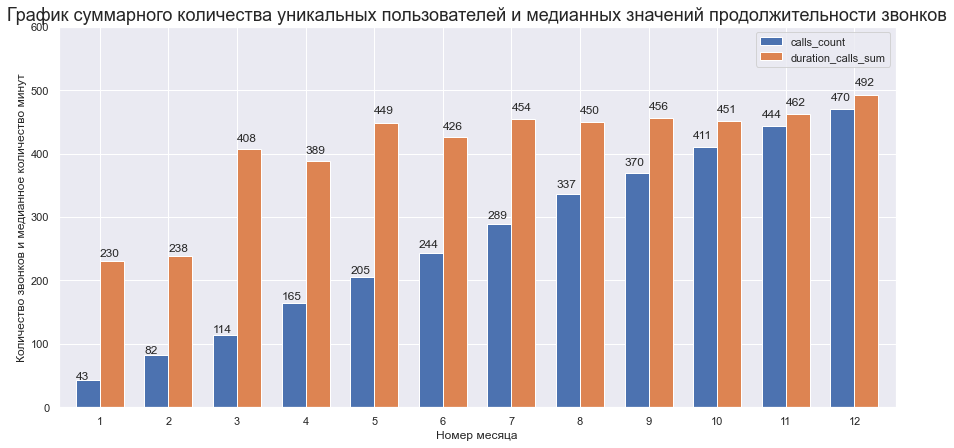

In [25]:
ax = calls_pivot.groupby(calls_pivot['month']).agg({'calls_count': 'count', 'duration_calls_sum': 'median'}).\
     plot.bar(figsize=(15, 7), rot=0, width=0.7)
ax.set_title('График суммарного количества уникальных пользователей и медианных значений продолжительности звонков', size=18)
ax.set_xlabel('Номер месяца')
ax.set_ylabel('Количество звонков и медианное количество минут')
ax.set_ylim(None, 600)

for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() * 1, p.get_height() * 1.03))
    
plt.show()    


По графику видим, что количество уникальных пользователей каждый месяц линейно растет. Наибольшее медианное значение суммарного количества использованных минут составляет 492 в декабре месяце, а наименьшее медианное количество минут составляет 230 в январе месяце. По графику видим, что с каждым месяцем привлекается все больше клиентов.

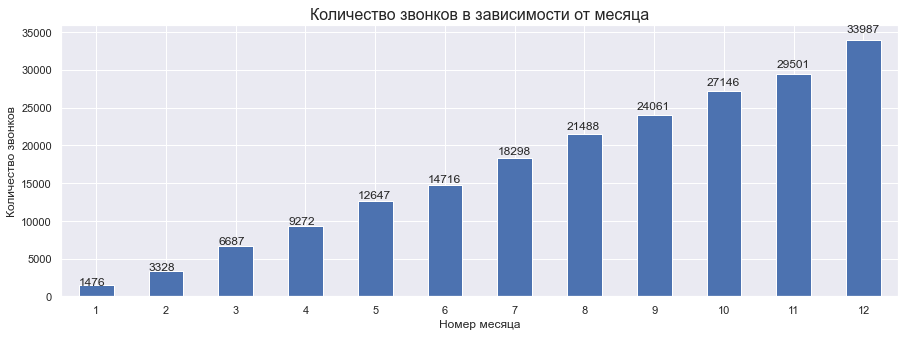

In [26]:
plt.figure(figsize=(15,5))
plt.title('Количество звонков в зависимости от месяца', size=16)
ax= calls_pivot.groupby(calls_pivot['month'])['calls_count'].sum().plot(kind='bar', rot=0)
for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() * 1, p.get_height() * 1.03))
plt.xlabel('Номер месяца')
plt.ylabel('Количество звонков')
plt.ylim(None, 36000)
plt.show()
    

Также наблюдается линейный рост количества звонков от месяца к месяцу (скорее всего из-за увелечения количества абонентов).

Напишем функцию для автоматического построения графиков:

In [27]:
def plot_subs(feature, data,
              suptitle, title1, title2, xlabel1, xlabel2, ylabel1, ylabel2, xlim=None):
    '''
    input:
        feature - название исследуемого признака
        data - данные, по которым строим график
        suptitle - наименование графиков
        title1, title2 - название гистограммы и боксплота
        xlabel1, xlabel2 - название оси X гистограммы и боксплота
        ylabel1, ylabel2 - название оси Y гистограммы и боксплота,
        xlim - ограничение по оси X
    output:
        None
    '''
    fig, axs = plt.subplots(1, 2, figsize=(18,7))
    plt.suptitle(suptitle, size=18)
    
#Построение гистограммы
    data[feature].hist(bins=100, edgecolor='black', ax=axs[0])
    axs[0].set_title(title1, size=15)
    axs[0].set_xlabel(xlabel1, size=13)
    axs[0].set_ylabel(ylabel1, size=13)
    
#Построение боксплота
    sns.boxplot(x=feature, data=data, ax=axs[1])
    axs[1].set_title(title2, size=15)
    axs[1].set_xlabel(xlabel2, size=13)
    axs[1].set_ylabel(ylabel2, size=13)
    
    if xlim is not None:
        axs[0].set_xlim(xlim)
        axs[1].set_xlim(xlim)

    plt.show()


Построим гистограмму и боксплот распределения израсходованных минут.

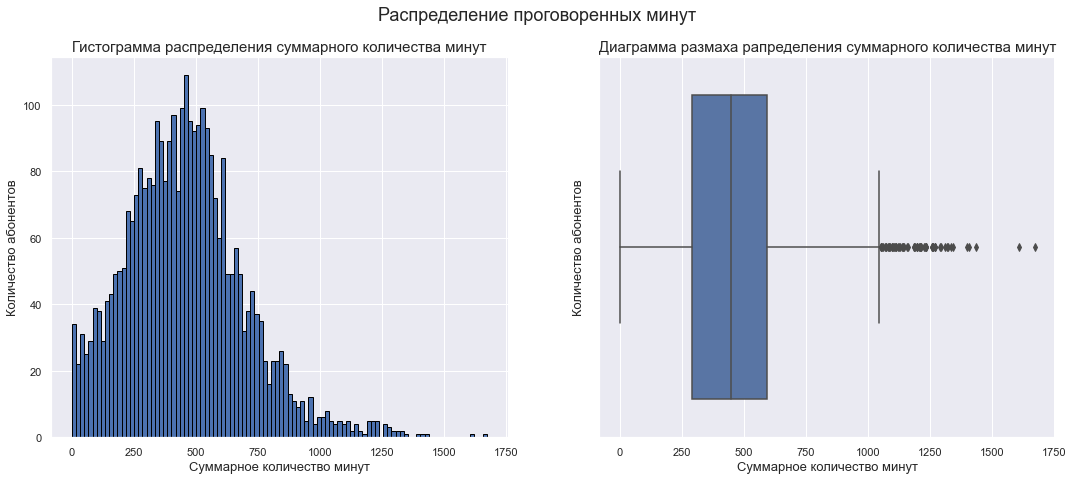

In [28]:
plot_subs('duration_calls_sum', calls_pivot, 'Распределение проговоренных минут', 
          'Гистограмма распределения суммарного количества минут', 'Диаграмма размаха рапределения суммарного количества минут', 
          'Суммарное количество минут', 'Суммарное количество минут', 
          'Количество абонентов', 'Количество абонентов')

По гистограмме видим, что наибольшее количество абонентов использует почти 500 минут в сумме, по диаграмме размаха можно сказать, что нормальные значения минут находятся в диапазоне от 0 до 1050 минут, все значения выходящие за данную отметку - выбросы.

In [29]:
calls_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   user_id             3174 non-null   int64
 1   month               3174 non-null   int64
 2   calls_count         3174 non-null   int64
 3   duration_calls_sum  3174 non-null   int64
dtypes: int64(4)
memory usage: 99.3 KB


**Таблица internet**

In [30]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month #Нахождение месяца интернет сессии

In [31]:
display(internet.sample(5))

,Unnamed: 0,id,mb_used,session_date,user_id,month
85255,85255,1290_285,667.679993,2018-12-18,1290,12
66408,66408,1227_5,0.000000,2018-07-16,1227,7
125995,125995,1423_452,345.239990,2018-04-24,1423,4
26434,26434,1092_100,92.629997,2018-12-18,1092,12
19627,19627,1066_108,570.799988,2018-10-26,1066,10


Поскольку в условии было обозначено, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов, поэтому округляем мегабайты в бОльшую сторону.

In [32]:
internet['mb_used_round'] = internet['mb_used'].map(math.ceil)

In [33]:
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values = 'mb_used_round', aggfunc = ['count', 'sum'])
internet_pivot = internet_pivot.reset_index()
internet_pivot.columns = ['user_id', 'month', 'count_mb', 'mb_used_round_sum']


In [34]:
internet_pivot[internet_pivot['mb_used_round_sum'] == 0]

,user_id,month,count_mb,mb_used_round_sum
592,1094,5,1,0
2298,1365,10,1,0


2 абонента  вообще не расходовали мегабайты интернета в течение месяца.

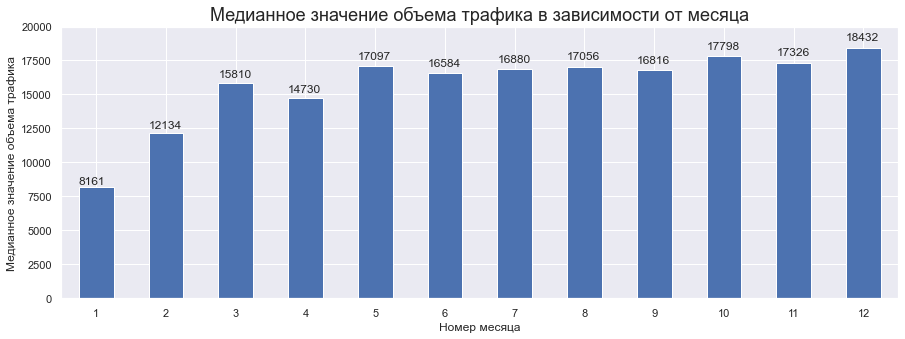

In [35]:
plt.figure(figsize=(15,5))
plt.title('Медианное значение объема трафика в зависимости от месяца', size = 18)
ax = internet_pivot.groupby(internet_pivot['month'])['mb_used_round_sum'].median().plot(kind='bar', rot=0)
for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() * 1, p.get_height() * 1.03))
plt.xlabel('Номер месяца')
plt.ylabel('Медианное значение объема трафика')
plt.ylim(None, 20000)
plt.show()


По графику видим, что наибольшее медианное значение израсходованного интернета 18 ГБ было в декабре, в январе же было наименьшее медианное значение израсходованного интернета - почти 8 ГБ.

Построим гистограмму и боксплот.

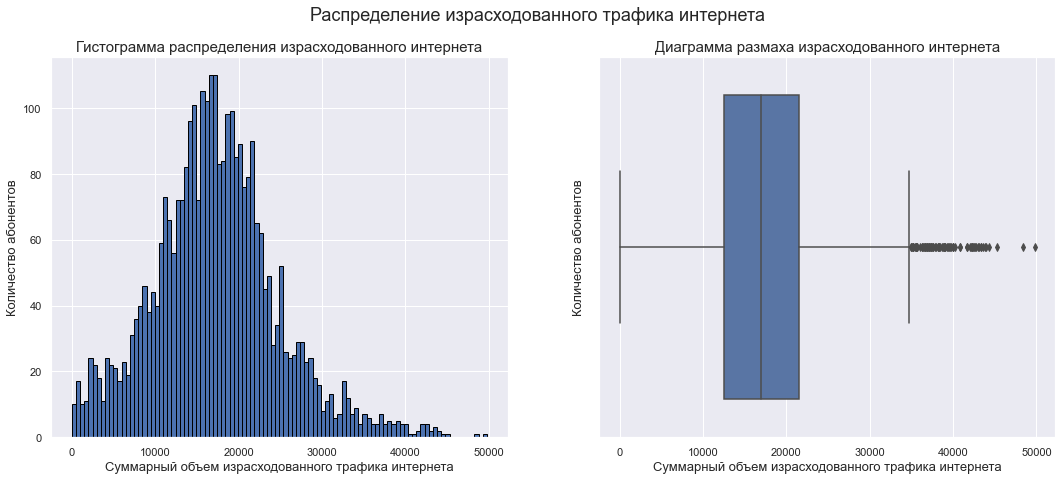

In [36]:
plot_subs('mb_used_round_sum', internet_pivot, 'Распределение израсходованного трафика интернета', 
          'Гистограмма распределения израсходованного интернета', 'Диаграмма размаха израсходованного интернета', 
          'Суммарный объем израсходованного трафика интернета', 'Суммарный объем израсходованного трафика интернета', 
          'Количество абонентов', 'Количество абонентов')

Из графика "Гистограмма распределения израсходованного интернета" видим, что наибольшее количество абонентов используют примерно 15 ГБ трафика. Гистограмма имеет форму колокола и стремится к нормальному распределению. Нормальные значения суммарного объема израсходованного трафика находятся в диапазоне от 0 до 35 ГБ. Все, что находится за пределами 35 ГБ будет являться выбросами

In [37]:
internet_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   user_id            3203 non-null   int64
 1   month              3203 non-null   int64
 2   count_mb           3203 non-null   int64
 3   mb_used_round_sum  3203 non-null   int64
dtypes: int64(4)
memory usage: 100.2 KB


Соединим таблицу internet_pivot с calls_pivot.

In [38]:
internet_merge = calls_pivot.merge(internet_pivot, on=['user_id', 'month'], how='outer')

**Таблица messages**

In [39]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month #Нахождение месяца, когда было отправлено сообщение

In [40]:
messages.sample(5)

,id,message_date,user_id,month
11757,1050_8,2018-08-08,1050,8
84917,1355_14,2018-11-03,1355,11
54235,1241_125,2018-12-18,1241,12
54408,1243_106,2018-10-16,1243,10
12066,1052_138,2018-07-30,1052,7


Создание сводной таблицы для анализа количества сообщений.

In [41]:
messages['user_id1'] = messages['user_id']
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='user_id1', aggfunc='count')
messages_pivot = messages_pivot.reset_index()
messages_pivot.columns = ['user_id', 'month', 'messages_count']

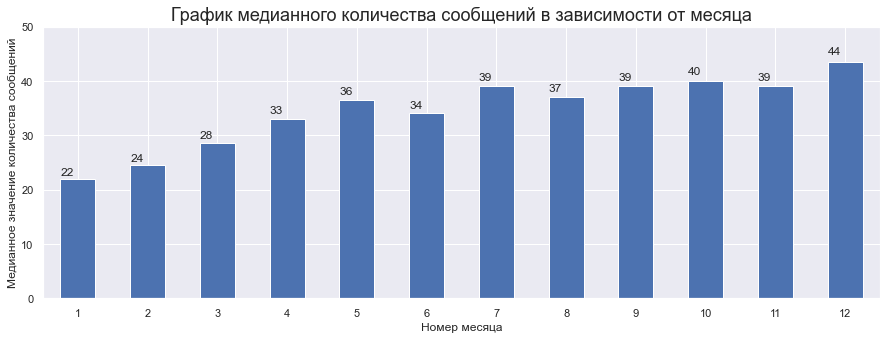

In [42]:
plt.figure(figsize=(15,5))
plt.title('График медианного количества сообщений в зависимости от месяца', size = 18)
ax = messages_pivot.groupby(messages_pivot['month'])['messages_count'].median().plot(kind='bar', rot=0)
for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() * 1, p.get_height() * 1.03))
plt.xlabel('Номер месяца')
plt.ylabel('Медианное значение количества сообщений')
plt.ylim(None, 50)
plt.show()


Наибольшее среднее значение по отправленным смс сообщениям наблюдается в январе 44 шт в месяц, при этом наименьшее медианное значение наблюдается в январе - 22 сообщения в месяц.

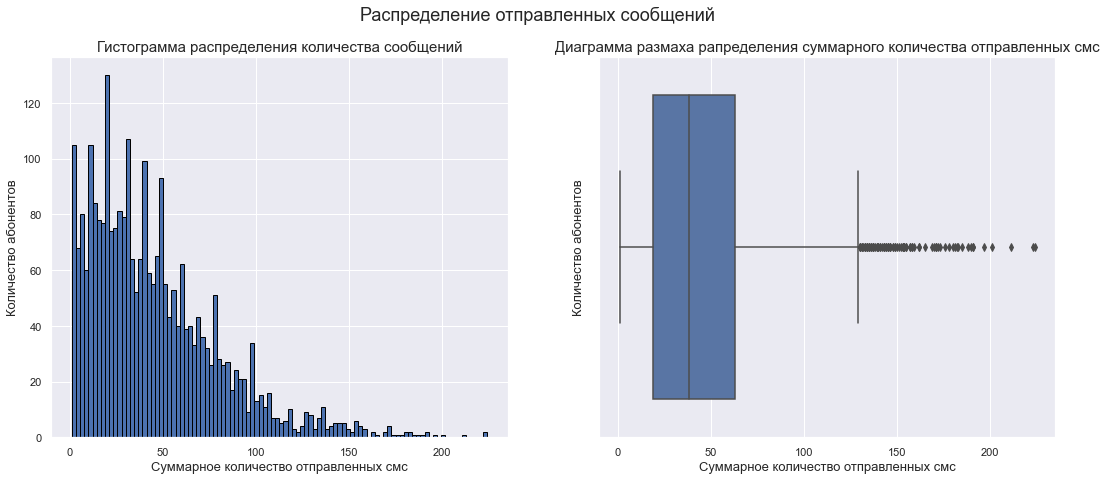

In [43]:
plot_subs('messages_count', messages_pivot, 'Распределение отправленных сообщений', 
          'Гистограмма распределения количества сообщений', 'Диаграмма размаха рапределения суммарного количества отправленных смс', 
          'Суммарное количество отправленных смс', 'Суммарное количество отправленных смс', 
          'Количество абонентов', 'Количество абонентов')

Наибольшее количество абонентов отправляют в месяц примерно 25 сообщений. Нормальные значения количества отправленных смсм сообщений сосредоточены в диапазоне от 1 до 60 сообщений. Все, что свыше этого диапазона - выбросы. 

Соединим таблицу messages_pivot с таблицей internet_merge.

In [44]:
messages_merge = internet_merge.merge(messages_pivot, on=[ 'user_id', 'month'], how='outer')

Далее соединим таблицу messages_merge с таблицей users.

In [45]:
users_merge = messages_merge.merge(users, on='user_id', how='left')

И, объединим получившуюся таблицу с таблицей tariffs.

In [46]:
df = users_merge.merge(tariffs, on='tariff', how='left')

Посмотрим таблицу, которая получилась.

In [47]:
df.sample(10)

,user_id,month,calls_count,duration_calls_sum,count_mb,mb_used_round_sum,messages_count,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
2969,1466,11,65.0,473.0,36.0,15234.0,NaN,37,NaN,Новосибирск,Рубен,Шевцов,2018-02-28,ultra,1000,30720,3000,1950,150,1,1
405,1064,7,47.0,313.0,67.0,20681.0,37.0,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart,50,15360,500,550,200,3,3
1292,1204,5,55.0,327.0,56.0,17474.0,NaN,18,NaN,Москва,Мирослава,Лазарева,2018-01-04,smart,50,15360,500,550,200,3,3
2783,1435,10,40.0,318.0,51.0,18860.0,NaN,32,NaN,Москва,Евфросинья,Азимова,2018-02-17,smart,50,15360,500,550,200,3,3
2362,1377,6,176.0,1290.0,10.0,4722.0,15.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,1000,30720,3000,1950,150,1,1
264,1043,10,67.0,512.0,71.0,23152.0,10.0,69,NaN,Ставрополь,Марианна,Родионова,2018-07-08,smart,50,15360,500,550,200,3,3
1887,1301,10,89.0,595.0,57.0,19661.0,NaN,26,NaN,Махачкала,Наида,Авраменко,2018-09-27,smart,50,15360,500,550,200,3,3
118,1016,12,16.0,94.0,34.0,19446.0,103.0,58,NaN,Омск,Марица,Сазонова,2018-11-21,ultra,1000,30720,3000,1950,150,1,1
3169,1498,10,41.0,247.0,59.0,20604.0,42.0,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3
2653,1418,12,64.0,413.0,58.0,19152.0,54.0,30,NaN,Новосибирск,Мстислав,Ахматов,2018-10-23,smart,50,15360,500,550,200,3,3


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

В целом таблицы мы соединили верно.
    
Однако при их соединении мы всё таки потеряли 2–х клиентов. В данный момент для нас это не критично, но в боевой задаче мы не захотим тепять эти данные.
    
Поэтому важно понимать, как так произошло.
    
В целом наша задача решается когда мы присоединяем данные к той таблице, в которой есть все пользователи.

</div>

In [48]:
print(f'Количество клиентов: {df.user_id.nunique()}')

Количество клиентов: 498


In [49]:
#Просмотр сколько памяти занимает обработка и количество пропусков в датафрейме
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   calls_count            3174 non-null   float64
 3   duration_calls_sum     3174 non-null   float64
 4   count_mb               3203 non-null   float64
 5   mb_used_round_sum      3203 non-null   float64
 6   messages_count         2717 non-null   float64
 7   age                    3214 non-null   int8   
 8   churn_date             187 non-null    object 
 9   city                   3214 non-null   object 
 10  first_name             3214 non-null   object 
 11  last_name              3214 non-null   object 
 12  reg_date               3214 non-null   object 
 13  tariff                 3214 non-null   object 
 14  messages_included      3214 non-null   int64  
 15  mb_p

In [50]:
df['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,3214.0,1251.590230,144.659172,1000.0,1125.0,1253.0,1378.75,1499.0
month,3214.0,8.317362,2.905413,1.0,6.0,9.0,11.00,12.0
calls_count,3174.0,63.833333,32.678036,1.0,41.0,63.0,83.00,244.0
duration_calls_sum,3174.0,456.931632,238.031270,0.0,290.0,447.0,592.00,1673.0
count_mb,3203.0,46.642523,18.696094,1.0,35.0,48.0,59.00,118.0
mb_used_round_sum,3203.0,17286.749610,7523.580332,0.0,12543.0,16985.0,21455.50,49789.0
messages_count,2717.0,45.283769,35.051363,1.0,19.0,38.0,63.00,224.0
age,3214.0,46.641568,16.586109,18.0,32.0,46.0,62.00,75.0
messages_included,3214.0,341.148102,438.044726,50.0,50.0,50.0,1000.00,1000.0
mb_per_month_included,3214.0,20067.405103,7082.491569,15360.0,15360.0,15360.0,30720.00,30720.0


Переведем значения типа object в категориальный тип.

In [52]:
#Создание категориального листа для перевода столбцов из типа данных object в тип данных category для оптимизации работы кода
cat_list = ['city', 'first_name', 'last_name', 'reg_date', 'tariff']

In [53]:
df[cat_list] = df[cat_list].astype('category') #Перевод столбцов из типа данных object в  тип category

Заполним нулями пропущенные значения в данных, предполагая, что если после слияния таблиц выяснилось, что данные о написанных сообщениях, исходящих звонках и использованных мегабайтах  отсутствовали, значит абонент предпочитал звонки остальным видам сервиса, и просто не пользовался включенными функциями.

In [54]:
#Создание листа с наименованием столбцов, в которых необходимо заполнить пустые значения нулями
fill_na_list = ['calls_count', 'duration_calls_sum', 'count_mb', 'mb_used_round_sum', 'messages_count']

In [55]:
df[fill_na_list] = df[fill_na_list].fillna(0)

In [56]:
#Перевод данных в тип int
float_list = ['calls_count', 'duration_calls_sum', 'count_mb', 'mb_used_round_sum', 'messages_count']
df[float_list] = df[float_list].astype('int')

In [57]:
#Cколько таблица использует memory usage после обработки
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   user_id                3214 non-null   int64   
 1   month                  3214 non-null   int64   
 2   calls_count            3214 non-null   int32   
 3   duration_calls_sum     3214 non-null   int32   
 4   count_mb               3214 non-null   int32   
 5   mb_used_round_sum      3214 non-null   int32   
 6   messages_count         3214 non-null   int32   
 7   age                    3214 non-null   int8    
 8   churn_date             187 non-null    object  
 9   city                   3214 non-null   category
 10  first_name             3214 non-null   category
 11  last_name              3214 non-null   category
 12  reg_date               3214 non-null   category
 13  tariff                 3214 non-null   category
 14  messages_included      3214 non-null   i

Напишем функцию, которая будет подсчитывать помесячную выручку с каждого пользователя при превышении, включенных в тарифный план минут, смс и количества Гб.

In [58]:
#Функция, для подсчета использованных сверх лимита смс, минут и Гб в денежном эквиваленте
def income(row):
    minutes = (row['duration_calls_sum'] - row['minutes_included']) * row['rub_per_minute']
    sms = (row['messages_count'] - row['messages_included']) * row['rub_per_message']
    gb = np.ceil(((row['mb_used_round_sum'] - row['mb_per_month_included']) / 1024))* row['rub_per_gb']
    
    over_limit = 0
    for i in [minutes, sms, gb]:
        if i>0:
            over_limit += i
    return over_limit

In [59]:
df['over_limit'] = df.apply(income, axis=1)

In [60]:
df.sample(5)

,user_id,month,calls_count,duration_calls_sum,count_mb,mb_used_round_sum,messages_count,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_limit
1515,1243,7,49,365,62,26404,60,74,NaN,Пермь,Артём,Леонтьев,2018-06-01,ultra,1000,30720,3000,1950,150,1,1,0.0
2438,1385,11,38,273,71,34360,126,26,NaN,Москва,Алиса,Дубинина,2018-01-13,ultra,1000,30720,3000,1950,150,1,1,600.0
2239,1359,8,95,681,40,11453,18,52,NaN,Москва,Константин,Абашкин,2018-07-27,smart,50,15360,500,550,200,3,3,543.0
870,1142,8,59,354,62,19883,43,51,NaN,Новосибирск,Симона,Алешкова,2018-03-24,smart,50,15360,500,550,200,3,3,1000.0
2086,1332,11,69,541,73,22353,47,23,NaN,Москва,Джозефина,Тетерина,2018-05-28,smart,50,15360,500,550,200,3,3,1523.0


Добавим в таблицу столбец с помесячной выручкой от каждого абонента с включением абонентской платы.

In [61]:
df['income_sum'] = df['over_limit'] + df['rub_monthly_fee']

In [62]:
df.head()

,user_id,month,calls_count,duration_calls_sum,count_mb,mb_used_round_sum,messages_count,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_limit,income_sum
0,1000,5,22,159,5,2256,22,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
1,1000,6,43,172,49,23257,60,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
2,1000,7,47,340,29,14016,75,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
3,1000,8,52,408,29,14070,81,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
4,1000,9,58,466,27,14581,57,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0


Построим график линейной зависимости помесячной выручки в зависимости от тарифа.

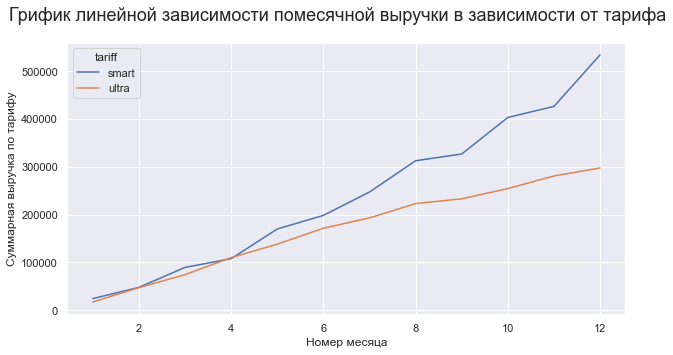

In [63]:
plot_data = df.groupby(['tariff', 'month'])['income_sum'].sum().reset_index()
plt.figure(figsize=(10, 5))
plt.suptitle('Грифик линейной зависимости помесячной выручки в зависимости от тарифа', size=18)
sns.lineplot(data = plot_data, x='month', y='income_sum', hue='tariff', palette='deep', legend='brief')
plt.xlabel('Номер месяца', size=12)
plt.ylabel('Суммарная выручка по тарифу', size=12)

plt.show()

По графику видим, что суммарная выручка по каждому тарифу линейно растет. По тарифу "Смарт" она возрастает более резко, а значит для бизнеса в 2018 году тариф был более выгоден главным образом за счет использования Гб и минут сверх лимита.

### Шаг 3. Проанализируйте данные <a class="anchor" id="step3"></a>

**Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц**

Для начала построим сводную таблицу со средними и медианными значениями всех показателей, а именно: сумма продолжительности звонков, количество сообщений и количество мегабайт в месяц. 

In [64]:
tariff_pivot = df.pivot_table(index='month', columns='tariff', 
                              values=['duration_calls_sum', 'messages_count', 'mb_used_round_sum'],
                             aggfunc=['median', 'mean'])
tariff_pivot

median                                                   \
       duration_calls_sum        mb_used_round_sum          messages_count   
tariff              smart  ultra             smart    ultra          smart   
month                                                                        
1                   162.5  382.0            7107.0  14808.0           15.0   
2                   258.0  168.0           12572.5   7335.5           20.0   
3                   409.0  403.0           15690.0  17513.0           23.0   
4                   368.5  453.0           14104.5  16662.0           28.0   
5                   433.0  519.0           16343.0  18717.0           30.0   
6                   400.0  479.0           16095.5  19495.5           28.0   
7                   414.0  542.0           15948.0  20034.0           29.0   
8                   432.0  500.0           16855.0  18945.0           27.0   
9                   435.0  520.0           16050.0  19675.0           30.0   
10                  427.5  533.0           17248.5  20359.0           30.0   
11                  428.5  546.0           17036.5  18398.0           28.0   
12                  471.0  584.0           17741.0  21994.0           29.0   

                           mean                                              \
             duration_calls_sum             mb_used_round_sum                 
tariff ultra              smart       ultra             smart         ultra   
month                                                                         
1       32.0         203.852941  428.111111       8524.441176  13153.555556   
2        5.5         298.689655  297.125000      11611.396552  11786.958333   
3       20.0         390.051948  489.648649      15123.857143  17551.972973   
4       17.0         367.133929  458.018182      13479.482143  16843.800000   
5       25.0         387.361702  510.328358      15825.198582  19381.194030   
6       27.5         395.640244  479.702381      15814.768293  18942.238095   
7       38.0         408.353234  545.791209      15763.512438  20514.648352   
8       40.0         421.468085  510.775701      16632.174468  19594.065421   
9       43.0         428.611538  539.443478      16324.526923  19222.208696   
10      49.0         426.136054  558.081301      16778.564626  20063.869919   
11      43.0         435.265823  541.380597      16917.531646  19805.313433   
12      51.0         478.560831  592.805755      18136.833828  21813.589928   

                                  
       messages_count             
tariff          smart      ultra  
month                             
1           18.235294  33.777778  
2           24.086207  21.958333  
3           31.857143  32.297297  
4           30.741071  31.563636  
5           33.773050  37.850746  
6           33.402439  41.726190  
7           33.751244  49.846154  
8           33.638298  48.439252  
9           33.638462  52.286957  
10          33.765306  58.430894  
11          34.075949  55.791045  
12          35.994065  60.611511

Из сводной таблицы видим: 
- клиенты тарифа "Смарт" и "Ультра" в среднем не выговаривают все количество минут, которое предоставляет им оператор за месяц. И в принципе средние и медианные значения израсходованных минут не сильно отличаются у двух тарифов. 
- Почти во все месяцы на тарифе Смарт клиенты выходили за пределы предоставляемого трафика интернета - 15360 МБ в месяц. Для бизнеса это выгодно, компания может получать прибыль с дополнительного предоставления интернета. Но, с другой стороны, в долгосрочной перспективе это может привести к тому, что клиенты начнут переходить на другие операторы связи с более выгодными условиями.
- С сообщениями ситуация такая же как и с минутами, на всех тарифах в среднем люди не выходят за пределы предоставляемого лимита.

Построим 'Гистограммы распределения израсходованного трафика по звонкам и интернету тарифа "Смарт"' для того чтобы проверить предположение, что люди предпочитают использовать интернет и таким образом созваниваться друг с другом (через сервисы Whatsapp или Telegram, например) чем использовать мобильную связь.

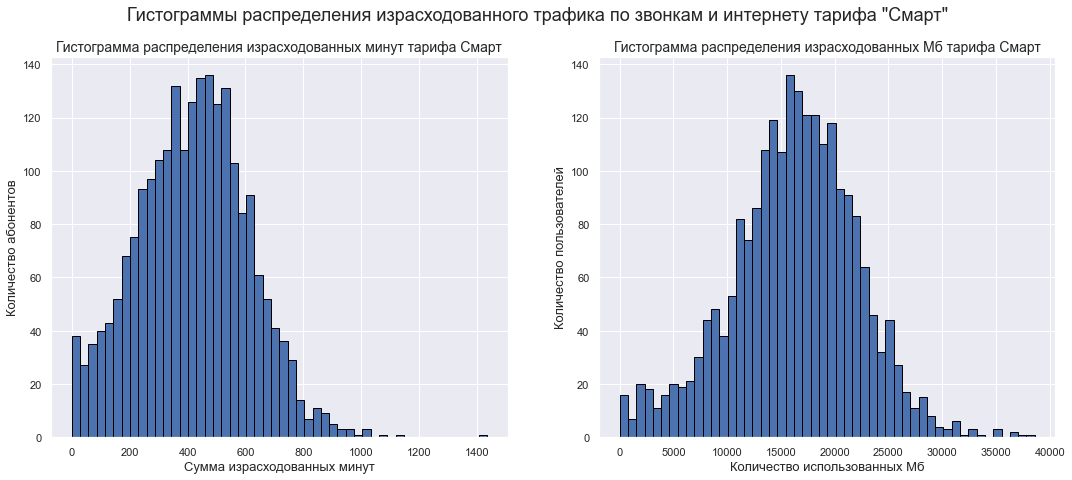

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(18,7))
plt.suptitle('Гистограммы распределения израсходованного трафика по звонкам и интернету тарифа "Смарт"', size=18)

#Построение гистограммы израсходованных минут тарифа Смарт
df[df['tariff'] == 'smart']['duration_calls_sum'].hist(bins=50, ax=axs[0], edgecolor='black')
axs[0].set_title('Гистограмма распределения израсходованных минут тарифа Смарт', size=14)
axs[0].set_xlabel('Сумма израсходованных минут', size=13)
axs[0].set_ylabel('Количество абонентов', size=13)

#Построение гистограммы использованных гигабайт тарифа Смарт
df[df['tariff'] == 'smart']['mb_used_round_sum'].hist(bins=50, ax=axs[1], edgecolor='black')
axs[1].set_title('Гистограмма распределения израсходованных Мб тарифа Смарт', size=14)
axs[1].set_xlabel('Количество использованных Мб', size=13)
axs[1].set_ylabel('Количество пользователей', size=13)



plt.show()

По первой гистограмме видно, что наибольшая группа абонентов тарифа Смарт используют в месяц 350 - 360 минут или 400-530 минут, что укладывается в лимит предоставляемого трафика (500 звонков в месяц). По мере расходования все большего количества минут после 500 лимитированных,количество абонентов, согласных доплачивать за дополнительные минуты снижается, что логично. И тем не менее, у гистограммы мы видим "хвост", находятся люди в нашей выборке, которые много разговаривают по мобильной связи, и котором сильно не хватает лимита в 500 минут, и которым было бы выгоднее перейти на тариф Ультра с предоставляемым лимитом в 3000 минут. Распределение схоже с Пуассоновским и смещено влево, обрезано на нуле.

Гистограмма распределения потраченных Мб на тарифе Смарт напоминает колокол, скорее симметрична и стремится к нормальному распределению. Мы видим, что наибольшее число пользователей используют примерно 15 100 Мб, что составляет практически весь лимит трафика. Достаточно большое количество людей (около 120) используют трафик в размере 20000 Мб, видимо покупая недостающие Мб (или почти 5 Гб). После этого значения наблюдается резкое снижение частоты от центра к границам допуска. Соответственно, все меньше и меньше людей покупают дополнитеные Гб интернета, хотя находятся в нашей выборке и такие, которые используют в месяц 38 000 Мб, что примерно равно 38 Гб, соответственно, в их тариф включено 15 Гб, а они дополнительно покупают еще 23 Гб. Им было бы более выгодно выбрать вместо этого тариф "Ультра". 

Построим 'Гистограммы распределения израсходованного трафика по звонкам и интернету тарифа "Ультра" для того чтобы проверить предположение, что люди предпочитают использовать интернет и таким образом созваниваться друг с другом (через сервисы Whatsapp или Telegram, например) чем использовать мобильную связь.


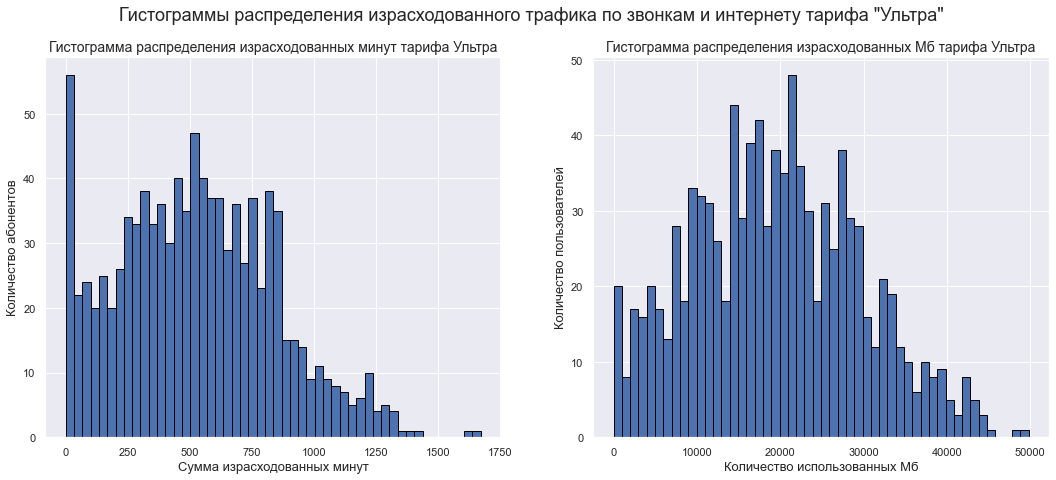

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(18,7))
plt.suptitle('Гистограммы распределения израсходованного трафика по звонкам и интернету тарифа "Ультра"', size=18)

#Построение  гистограммы израсходованных минут тарифа Ультра
df[df['tariff'] == 'ultra']['duration_calls_sum'].hist(bins=50, ax=axs[0], edgecolor='black')
axs[0].set_title('Гистограмма распределения израсходованных минут тарифа Ультра', size=14)
axs[0].set_xlabel('Сумма израсходованных минут', size=13)
axs[0].set_ylabel('Количество абонентов', size=13)

#Построение гистограммы использованных мегабайт тарифа Ультра
df[df['tariff'] == 'ultra']['mb_used_round_sum'].hist(bins=50, ax=axs[1], edgecolor='black')
axs[1].set_title('Гистограмма распределения израсходованных Мб тарифа Ультра', size=14)
axs[1].set_xlabel('Количество использованных Мб', size=13)
axs[1].set_ylabel('Количество пользователей', size=13)

plt.show()

Первая гистограмма - распределения израсходованных минут тарифа ультра несимметрична и неравномерна. Самый большой пик наблюдается в диапазоне 0-33 минут. Можно предположить, что абоненты, входящие в эту группу, не склонны использовать мобильную связь, а используют вместо нее интернет для звонков. А возможно они изначально выбрали такой тариф ради большого трафика на интернет. Наибольшая группа людей, пользующаяся тарифом "Ультра" использует минуты в диапазоне 250 - 750 минут. Никто из абонентов не расходует полное количество минут, входящих в трафик.

Проанализируем гистограмму распределения израсходованных Мб тарифа Ультра. Гистограмма крайне не равномерна, наблюдаются пики и падения по всей диаграмме с некоторой периодичностью.Выборка пользователей не равномерная, встречаются как люди, которые используют высокое количество Мб (например около 48 человек используют 22 000 мб), так и те, которые пользуются интернетом крайне мало (до 500 Гб). В "хвосте" находятся пользователи, которые доплачивают за дополнительные Гб интернета. Даже есть те, которые доплачивают почти за 20 Гб интернета.

Построим гистограммы распределения количества сообщений на тарифе Смарт и Ультра.

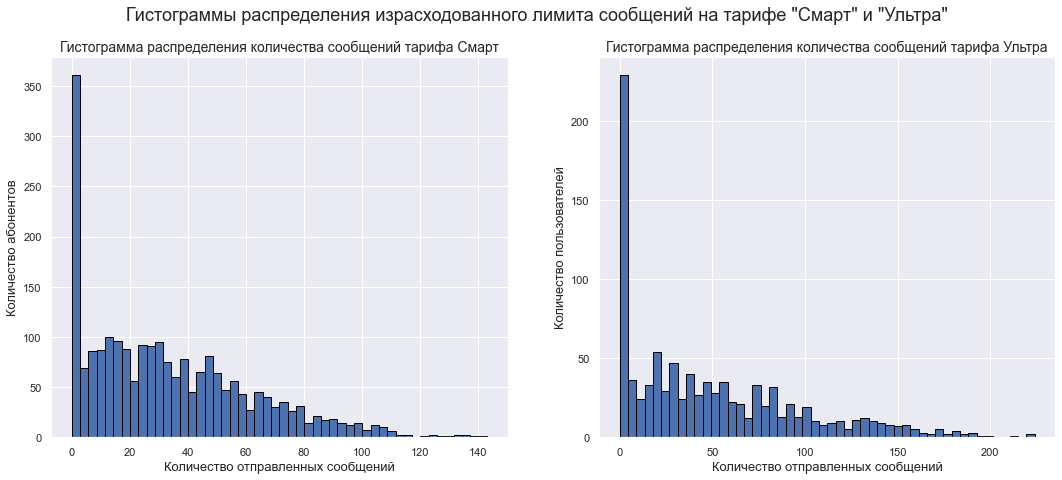

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(18,7))
plt.suptitle('Гистограммы распределения израсходованного лимита сообщений на тарифе "Смарт" и "Ультра"', size=18)

#Построение гистограммы израсходованных минут тарифа Смарт
df[df['tariff'] == 'smart']['messages_count'].hist(bins=50, ax=axs[0], edgecolor='black')
axs[0].set_title('Гистограмма распределения количества сообщений тарифа Смарт', size=14)
axs[0].set_xlabel('Количество отправленных сообщений', size=13)
axs[0].set_ylabel('Количество абонентов', size=13)

#Построение гистограммы использованных гигабайт тарифа Смарт
df[df['tariff'] == 'ultra']['messages_count'].hist(bins=50, ax=axs[1], edgecolor='black')
axs[1].set_title('Гистограмма распределения количества сообщений тарифа Ультра', size=14)
axs[1].set_xlabel('Количество отправленных сообщений', size=13)
axs[1].set_ylabel('Количество пользователей', size=13)

plt.show()

По полученным гистограммам видим, что в целом распределение на обоих графиках схоже, а значит и поведение почти всех клиентов, относящихся к разным тарифам, тоже схоже. Например, в обоих случаях мы наблюдаем пик в диапазоне 0-3 сообщений в месяц у клиентов тарифа Смарт (примерно у 350 чел.) и пик в диапазоне 0-5 сообщений в месяц у пользователей тарифа Ультра (около 210 чел.)
У пользователей тарифа Смарт мы видим тенденцию расходования лимита сообщений и плату за дальнейшие сообщения.
Абоненты тарифа Ультра наоборот никогда не выходят за лимит предоставляемого количества сообщений.

**Среднее количество, дисперсия и стандартное отклонение.**

Мы разделили генеральную совокупность на 2 выборки: тариф Смарт и тариф Ультра. По этим выборкам посчитали среднее, дисперсию и стандартное отклонение по количеству минут, использованных мегабайт и количеству сообщений.

**Количество минут**

___Тариф Смарт___

In [68]:
print('Среднее по количеству минут в тарифе Смарт: {:.2f}'.format(df[df['tariff'] == 'smart']
                                                                  ['duration_calls_sum'].mean()))
print('Дисперсия по количеству минут в тарифе Смарт: {:.2f}'.format(np.var(df[df['tariff'] == 'smart']
                                                                           ['duration_calls_sum'])))
print('Стандартное отклонение по количеству минут в тарифе Смарт: {:.2f}'.format(np.std(df[df['tariff'] == 'smart']
                                                                                        ['duration_calls_sum'], ddof=1)))


Среднее по количеству минут в тарифе Смарт: 417.93
Дисперсия по количеству минут в тарифе Смарт: 36203.07
Стандартное отклонение по количеству минут в тарифе Смарт: 190.31


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Кстати весь расчет можно было сделать с помощью сводных таблиц.
    
Где в атрибуте `aggfunc`, мы указали бы сразу несколько функций, которые должны примениться к нашим данным. 
    
</div>

___Тариф Ультра___

In [69]:
print('Среднее по количеству минут в тарифе Ультра: {:.2f}'.format(df[df['tariff'] == 'ultra']
                                                                  ['duration_calls_sum'].mean()))
print('Дисперсия по количеству минут в тарифе Ультра: {:.2f}'.format(np.var(df[df['tariff'] == 'ultra']
                                                                           ['duration_calls_sum'])))
print('Стандартное отклонение по количеству минут в тарифе Ультра: {:.2f}'.format(np.std(df[df['tariff'] == 'ultra']
                                                                                        ['duration_calls_sum'], ddof=1)))


Среднее по количеству минут в тарифе Ультра: 526.62
Дисперсия по количеству минут в тарифе Ультра: 100771.22
Стандартное отклонение по количеству минут в тарифе Ультра: 317.61


- Среднее по количеству минут в тарифе Смарт равно 417,93, а в тарифе Ультра составляет 526,62 , что логично, лимит включенных минут в тарифе Ультра больше, соответственно люди покупают тариф Ультра чтобы пользоваться бОльшим количеством минут. 
- Дисперсия по количеству минут в тарифе Смарт равна 36203,07, а в тарифе Ультра 100771.22
- Стандартное отклонение по количеству минут в тарифе Смарт равно 190.31. Стандартное отклонение по количеству минут в тарифе Ультра равно 317.61

**Количество использованных мегабайт**

___Тариф Смарт___

In [70]:
print('Среднее по количеству использованных мегабайт в тарифе Смарт: {:.2f}'.format(df[df['tariff'] == 'smart']
                                                                  ['mb_used_round_sum'].mean()))
print('Дисперсия по количеству использованных мегабайт в тарифе Смарт: {:.2f}'.format(np.var(df
                                                                                             [df['tariff'] == 'smart']
                                                                                             ['mb_used_round_sum'])))
print('Стандартное отклонение по количеству использованных мегабайт в тарифе Смарт: {:.2f}'.format(np.std(df
                                                                                                          [df['tariff'] == 'smart']
                                                                                        ['mb_used_round_sum'], ddof=1)))


Среднее по количеству использованных мегабайт в тарифе Смарт: 16229.19
Дисперсия по количеству использованных мегабайт в тарифе Смарт: 34530412.74
Стандартное отклонение по количеству использованных мегабайт в тарифе Смарт: 5877.58


___Тариф Ультра___

In [71]:
print('Среднее по количеству использованных мегабайт в тарифе Ультра: {:.2f}'.format(df[df['tariff'] == 'ultra']
                                                                  ['mb_used_round_sum'].mean()))
print('Дисперсия по количеству использованных мегабайт в тарифе Ультра: {:.2f}'.format(np.var(df[df['tariff'] == 'ultra']
                                                                           ['mb_used_round_sum'])))
print('Стандартное отклонение по количеству использованных мегабайт в тарифе Ультра: {:.2f}'.format(np.std(df[df['tariff'] == 'ultra']
                                                                                        ['mb_used_round_sum'], ddof=1)))


Среднее по количеству использованных мегабайт в тарифе Ультра: 19486.90
Дисперсия по количеству использованных мегабайт в тарифе Ультра: 101832133.11
Стандартное отклонение по количеству использованных мегабайт в тарифе Ультра: 10096.32


В результате получили, что:
- Среднее по количеству использованных мегабайт в тарифе Смарт и Ультра не сильно различается и составляет 16229.19 и 19486.90. Исходя из полученного результата можно сказать, что для первой группы клиентов, использующих тариф Смарт, включенных мегабайт не будет хватать и в среднем каждый будет покупать дополнительно 1 Гб интернета, а для второй группы клиентов в среднем включенного трафика слишком много,т.к. лимит составляет 30 Гб (наше среднее гораздо меньше)
- Дисперсия по количеству использованных мегабайт в тарифе Смарт равна 34530412.74, а в тарифе Ультра равна 101832133.11
- Стандартное отклонение по количеству использованных мегабайт в тарифе Смарт оказалось равно 5877.58, стандартное отклонение по количеству использованных мегабайт в тарифе Ультра - 10096.32

**Количество сообщений**

___Тариф Смарт___

In [72]:
print('Среднее по количеству сообщений в тарифе Смарт: {:.2f}'.format(df[df['tariff'] == 'smart']
                                                                  ['messages_count'].mean()))
print('Дисперсия по количеству сообщений в тарифе Смарт: {:.2f}'.format(np.var(df[df['tariff'] == 'smart']
                                                                           ['messages_count'])))
print('Стандартное отклонение по количеству сообщений в тарифе Смарт: {:.2f}'.format(np.std(df[df['tariff'] == 'smart']
                                                                                        ['messages_count'], ddof=1)))

Среднее по количеству сообщений в тарифе Смарт: 33.38
Дисперсия по количеству сообщений в тарифе Смарт: 796.46
Стандартное отклонение по количеству сообщений в тарифе Смарт: 28.23


___Тариф Ультра___

In [73]:
print('Среднее по количеству сообщений в тарифе Ультра: {:.2f}'.format(df[df['tariff'] == 'ultra']
                                                                  ['messages_count'].mean()))
print('Дисперсия по количеству сообщений в тарифе Ультра: {:.2f}'.format(np.var(df[df['tariff'] == 'ultra']
                                                                           ['messages_count'])))
print('Стандартное отклонение по количеству сообщений в тарифе Ультра: {:.2f}'.format(np.std(df[df['tariff'] == 'ultra']
                                                                                        ['messages_count'], ddof=1)))


Среднее по количеству сообщений в тарифе Ультра: 49.36
Дисперсия по количеству сообщений в тарифе Ультра: 2282.95
Стандартное отклонение по количеству сообщений в тарифе Ультра: 47.80


- Среднее по количеству сообщений в тарифе Смарт и Ультра невысокое и составляет 33.38 и 49.36.
- Дисперсия по количеству сообщений различается в двух тарифах достаточно сильно, почти в 3 раза и составляет в тарифе Смарт: 796.46, а в тарифе Ультра 2282.95
- Стандартное отклонение по количеству сообщений в тарифе Смарт составляет 28.23, а в тарифе Ультра - 47.80

___Вопрос к ревьюеру:___ Не очень поняла какая интерпретация результатов ожидается от меня в данном случае, особенно по дисперсии и стандартному отклонению. Написала как думаю. Какую экономическую ценность можно привязать к этим показателям - дисперсии и стандартному отклонению?

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>
   
Дисперсия нам говорит о том, как распределены данные.
    
Если дисперсии данных сильно отличаются или равны, то это влияет на выбор метода проверки статистической гипотезы, чтобы проверка была максимально корректной.
    
Стандартное отклонение позволяет нам оценить насколько могут отклоняться данные у каждого клиента, как в бОльшую сторону, так и в меньшую.
    
Рекомендую посмотреть курс по Основам статистики на stepik.ru с Анатолием Карповым. Очень полезный и информативный, ну и самое главное в легкой форме идёт подача информации. 
    
---

Очень детально проверили наш анализ пользователей, выводы абсолютно логичны и даже придраться не к чему 😊👍
    
Предлагаю приступить к проверке наших гипотез.
    
</div>

### Шаг 4. Проверьте гипотезы <a class="anchor" id="step4"></a>

**Проверка гипотезы "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"**

Проведем тест Стъюдента для проверки нулевой гипотезы о равенстве средней выручки пользователей тарифов "Ультра" и "Смарт". Тогда альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Выберем критический уровень статистической значимости альфа 5%.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Гипотезы сформулированы верно.
    
    
**Best practies:**
    
Перед проверкой гипотезы рекомендую проверить дисперсии выборок, чтобы корректно определить атрибут `equal_val` в Т–тесте.
    
В том числе стоит визуализировать распределение каждой выборки. 
    
Т.к. при выполнении лучших практик, мы сможем сделать проект более последовательным. 
    
</div>

In [74]:
alpha = .05
results_tariffs = st.ttest_ind(df[df['tariff'] == 'smart']['income_sum'], df[df['tariff'] == 'ultra']['income_sum'], equal_var = False )
print('p-значение:', results_tariffs.pvalue)

if (results_tariffs.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Если код не помещается в одну строку, рекомендую переносить его на следующую подстроку, с помощью обратного слеша. Так код читается быстрее и понятнее.
    
</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>

В конструкции `if`можно писать условие без скобок. Для логики это неважно, но чем меньше символов в коде — тем легче его читать. Чтобы продемонстрировать коллегам хороший стиль кода, привыкай писать условия без скобок.
</div>

Получили, что нулевая гипотеза о равенстве средней выручки тарифов "Смарт" и "Ультра" отверглась, тогда не отвергается альтернативная гипотеза - ___средняя выручка пользователей тарифов «Ультра» и «Смарт» различается___.

**Проверка гипотезы "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".**

Проведем тест Стъюдента для проверки нулевой гипотезы о равенстве средней выручки пользователей из Москвы и выручки пользователей из других регионов. Тогда альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Выберем критический уровень статистической значимости альфа 5%.

In [75]:
alpha = .05
results_tariffs = st.ttest_ind(df[df['city'] == 'Москва']['income_sum'], df[df['city'] != 'Москва']['income_sum'])
print('p-значение:', results_tariffs.pvalue)

if (results_tariffs.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


Получили, что ___нулевая гипотеза о равенстве средней выручки пользователей из Москвы и выручки пользователей из других регионов не отверглась___. Полученное значение p-value 0.53 говорит о том, что хотя средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов неодинакова, с вероятностью почти в 51% такое или большее различие можно получить случайно. Это слишком большая вероятность чтобы делать выводы о значимом различиии между средней выручкой пользователей из Москвы и пользователей из других регионов.

### Шаг 5. Напишите общий вывод <a class="anchor" id="step5"></a>

Мы провели анализ тарифных планов компании «Мегалайн» — федерального оператора сотовой связи по двум тарифным планам: «Смарт» и «Ультра». 
У нас было 5 таблиц с данными: 
- calls (информация о звонках), 
- internet (информация об интернет-сессиях), 
- messages (информация о сообщениях), 
- tariffs (информация о тарифах),
- users (информация о пользователях)

Для дальнейшей работы нам необходимо было объединить данные таблицы в одну, сгруппировав информацию по месяцам, уникальным пользователям и сумме израсходованных минут, использованных мегабайт и количеству отправленных сообщений. Сначала мы понизили разрядность некоторых показателей, чтобы оптимизировать работу с данными.
        
Сначала мы рассмотрели каждую таблицу по отдельности и привели к удобному виду, а также провели небольшой анализ по каждой таблице:

**- По звонкам:**
* Поскольку в условии было обозначено, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов, поэтому округлили продолжительность разговора в минутах в бОльшую сторону. 
* В данных было почти 20% звонков со значением 0 минут (а мы не знали природу появления данных нулей - это может быть как пропущенные звонки, так и ошибки в данных). Сделали допущение, что таким образом обозначены пропущенные звонки, поскольку мы считали суммарное количество минут каждого абонента по месяцам, пропущенные значения не должны сильно исказить результат.
* Получили, что у нескольких абонентов за месяц не было ни одной проговоренной минуты, а таких абонентов 3 шт - с user_id 1240, 1257, 1373. Количество звонков за месяц у них также небольшое - 1 или 2. Можно предположить, что возможно люди в эти месяцы куда-то уезжали и не разговаривали по мобильному телефону, либо у них 2 телефона и они используют один из них исключительно для интернета и т.д.
* Количество уникальных пользователей каждый месяц линейно возрастало. Наибольшее медианное значение суммарного количества использованных минут составляет 492 в декабре месяце, а наименьшее медианное количество минут составляет 230 в январе месяце. С каждым месяцем привлекается все больше клиентов.
Также наблюдается линейный рост количества звонков от месяца к месяцу (скорее всего из-за увелечения количества абонентов).
* После построения гистограммы мы увидели, что наибольшее количество абонентов использует почти 500 минут в сумме, по диаграмме размаха можно сказать, что нормальные значения минут находятся в диапазоне от 0 до 1050 минут, все значения выходящие за данную отметку - выбросы.

**- По мобильному интернету:**
* Поскольку в условии было обозначено, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов, поэтому округлили мегабайты в бОльшую сторону.
* 2 абонента  вообще не расходовали мегабайты интернета в течение месяца.
* Наибольшее медианное значение израсходованного интернета 18 ГБ было в декабре, в январе же было наименьшее медианное значение израсходованного интернета - почти 8 ГБ.
* Построив "Гистограмму распределения израсходованного интернета" мы увидели, что наибольшее количество абонентов используют примерно 15 ГБ трафика. Гистограмма имеет форму колокола и стремится к нормальному распределению. Нормальные значения суммарного объема израсходованного трафика находятся в диапазоне от 0 до 35 ГБ. Все, что находится за пределами 35 ГБ  является выбросами.

**- По количеству сообщений:**
* Наибольшее среднее значение по отправленным смс сообщениям наблюдается в январе 44 шт в месяц, при этом наименьшее медианное значение наблюдается в январе - 22 сообщения в месяц.
* Наибольшее количество абонентов отправляют в месяц примерно 25 сообщений. Нормальные значения количества отправленных смс сообщений сосредоточены в диапазоне от 1 до 60 сообщений. Все, что свыше этого диапазона - выбросы. 

После соединения всех таблиц мы заполнили нулями пропущенные значения в данных, предполагая, что если после слияния таблиц выяснилось, что данные о написанных сообщениях, исходящих звонках и использованных мегабайтах отсутствовали, значит абонент предпочитал звонки остальным видам сервиса, и просто не пользовался включенными функциями.
Далее написали функцию, которая подсчитала помесячную выручку с каждого пользователя при превышении, включенных в тарифный план минут, смс и количества Гб и добавили в таблицу столбец с помесячной выручкой от каждого абонента с включением абонентской платы. Оказалось, что суммарная выручка по каждому тарифу линейно растет. По тарифу "Смарт" она возрастает более резко, а значит для бизнеса в 2018 году тариф был более выгоден главным образом за счет использования Гб и минут сверх лимита.

Построив сводную таблицу со средними и медианными значениями всех показателей, а именно: сумма продолжительности звонков, количество сообщений и количество мегабайт в месяц мы увидели, что:
видим:
* клиенты тарифа "Смарт" и "Ультра" в среднем не выговаривают все количество минут, которое предоставляет им оператор за месяц. И в принципе средние и медианные значения израсходованных минут не сильно отличаются у двух тарифов.
* Почти во все месяцы на тарифе Смарт клиенты выходили за пределы предоставляемого трафика интернета - 15360 МБ в месяц. Для бизнеса это выгодно, компания может получать прибыль с дополнительного предоставления интернета. Но, с другой стороны, в долгосрочной перспективе это может привести к тому, что клиенты начнут переходить на другие операторы 
* С сообщениями ситуация такая же как и с минутами, на всех тарифах в среднем люди не выходят за пределы предоставляемого лимита.

Далее мы построили 'Гистограммы распределения израсходованного трафика по звонкам и интернету тарифа "Смарт"' для того чтобы проверить предположение, что люди предпочитают использовать интернет и таким образом созваниваться друг с другом (через сервисы Whatsapp или Telegram, например) чем использовать мобильную связь. Получили следующие результаты: 

* Наибольшая группа абонентов тарифа Смарт используют в месяц 350 - 360 минут или 400-530 минут, что укладывается в лимит предоставляемого трафика (500 звонков в месяц). По мере расходования все большего количества минут после 500 лимитированных,количество абонентов, согласных доплачивать за дополнительные минуты снижается, что логично. И тем не менее, у гистограммы мы видим "хвост", находятся люди в нашей выборке, которые много разговаривают по мобильной связи, и котором сильно не хватает лимита в 500 минут, и которым было бы выгоднее перейти на тариф Ультра с предоставляемым лимитом в 3000 минут. Распределение схоже с Пуассоновским и смещено влево, обрезано на нуле.

* Гистограмма распределения потраченных Мб на тарифе Смарт напоминает колокол, скорее симметрична и стремится к нормальному распределению. Мы видим, что наибольшее число пользователей используют примерно 15 100 Мб, что составляет практически весь лимит трафика. Достаточно большое количество людей (около 120) используют трафик в размере 20000 Мб, видимо покупая недостающие Мб (или почти 5 Гб). После этого значения наблюдается резкое снижение частоты от центра к границам допуска. Соответственно, все меньше и меньше людей покупают дополнитеные Гб интернета, хотя находятся в нашей выборке и такие, которые используют в месяц 38 000 Мб, что примерно равно 38 Гб, соответственно, в их тариф включено 15 Гб, а они дополнительно покупают еще 23 Гб. Им было бы более выгодно выбрать вместо этого тариф "Ультра".

Построили 'Гистограммы распределения израсходованного трафика по звонкам и интернету тарифа "Ультра" и получили, что:

* Первая гистограмма - распределения израсходованных минут тарифа ультра несимметрична и неравномерна. Самый большой пик наблюдается в диапазоне 0-33 минут. Можно предположить, что абоненты, входящие в эту группу, не склонны использовать мобильную связь, а используют вместо нее интернет для звонков. А возможно они изначально выбрали такой тариф ради большого трафика на интернет. Наибольшая группа людей, пользующаяся тарифом "Ультра" использует минуты в диапазоне 250 - 750 минут. Никто из абонентов не расходует полное количество минут, входящих в трафик.

* Гистограмма распределения израсходованных Мб тарифа Ультра крайне не равномерна, наблюдаются пики и падения по всей диаграмме с некоторой периодичностью.Выборка пользователей не равномерная, встречаются как люди, которые используют высокое количество Мб (например около 48 человек используют 22 000 мб), так и те, которые пользуются интернетом крайне мало (до 500 Гб). В "хвосте" находятся пользователи, которые доплачивают за дополнительные Гб интернета. Даже есть те, которые доплачивают почти за 20 Гб интернета.

Построили гистограммы распределения количества сообщений на тарифе Смарт и Ультра и выяснили, что в целом распределение на обоих графиках схоже, а значит и поведение почти всех клиентов, относящихся к разным тарифам, тоже схоже. Например, в обоих случаях мы наблюдаем пик в диапазоне 0-3 сообщений в месяц у клиентов тарифа Смарт (примерно у 350 чел.) и пик в диапазоне 0-5 сообщений в месяц у пользователей тарифа Ультра (около 210 чел.) У пользователей тарифа Смарт мы видим тенденцию расходования лимита сообщений и плату за дальнейшие сообщения. Абоненты тарифа Ультра наоборот никогда не выходят за лимит предоставляемого количества сообщений.

Мы разделили генеральную совокупность на 2 выборки: тариф Смарт и тариф Ультра. По этим выборкам посчитали среднее, дисперсию и стандартное отклонение по количеству минут, использованных мегабайт и количеству сообщений и получили следующие результаты:
- Среднее по количеству минут в тарифе Смарт равно 417,93, а в тарифе Ультра составляет 526,62 , что логично, лимит включенных минут в тарифе Ультра больше, соответственно люди покупают тариф Ультра чтобы пользоваться бОльшим количеством минут. 
- Дисперсия по количеству минут в тарифе Смарт равна 36203,07, а в тарифе Ультра 100771.22
- Стандартное отклонение по количеству минут в тарифе Смарт равно 190.31. Стандартное отклонение по количеству минут в тарифе Ультра равно 317.61
- Среднее по количеству использованных мегабайт в тарифе Смарт и Ультра не сильно различается и составляет 16229.19 и 19486.90. Исходя из полученного результата можно сказать, что для первой группы клиентов, использующих тариф Смарт, включенных мегабайт не будет хватать и в среднем каждый будет покупать дополнительно 1 Гб интернета, а для второй группы клиентов в среднем включенного трафика слишком много,т.к. лимит составляет 30 Гб (наше среднее гораздо меньше)
- Дисперсия по количеству использованных мегабайт в тарифе Смарт равна 34530412.74, а в тарифе Ультра равна 101832133.11
- Стандартное отклонение по количеству использованных мегабайт в тарифе Смарт оказалось равно 5877.58, стандартное отклонение по количеству использованных мегабайт в тарифе Ультра - 10096.32
- Среднее по количеству сообщений в тарифе Смарт и Ультра невысокое и составляет 33.38 и 49.36.
- Дисперсия по количеству сообщений различается в двух тарифах достаточно сильно, почти в 3 раза и составляет в тарифе Смарт: 796.46, а в тарифе Ультра 2282.95
- Стандартное отклонение по количеству сообщений в тарифе Смарт составляет 28.23, а в тарифе Ультра - 47.80

Мы провели тест Стъюдента для проверки нулевой гипотезы о равенстве средней выручки пользователей тарифов "Ультра" и "Смарт". Альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Выбрали критический уровень статистической значимости альфа 5%.
Получили, что нулевая гипотеза о равенстве средней выручки тарифов "Смарт" и "Ультра" отверглась, тогда не отвергается альтернативная гипотеза - ___средняя выручка пользователей тарифов «Ультра» и «Смарт» различается___.

Провели тест Стъюдента для проверки нулевой гипотезы о равенстве средней выручки пользователей из Москвы и выручки пользователей из других регионов. Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Выбрали критический уровень статистической значимости альфа 5%.
Получили, что ___нулевая гипотеза о равенстве средней выручки пользователей из Москвы и выручки пользователей из других регионов не отверглась___. Полученное значение p-value 0.53 говорит о том, что хотя средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов неодинакова, с вероятностью почти в 51% такое или большее различие можно получить случайно. Это слишком большая вероятность чтобы делать выводы о значимом различиии между средней выручкой пользователей из Москвы и пользователей из других регионов.


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Выводы понятны и логичны, а самое главное подкреплены выявленными фактами.
       
В целом сам проект выполнен на хорошем уровне! На протяжении всей работы чувствуется глубина проработки задачи и это безусловный плюс для нас. Было использовано большое количество методов, которые будут помогать тебе в дальнейших проектах.
    
Не стоит забывать про оформление своей работы, это важный такой же важный этап. Рекомендую «не стесняться» использовать ячейки типа **markdown** там где нам необходимо отобразить свои размышления, в том числе с использованием дополнительной стилизации.
    
Успехов тебе в новых проектах! 
    
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера (общий):</b>

Рекомендую посмотреть на дополнительную стилизацию ячеек типа **markdown**.
    
**Жирный**
*Курсив*
    
--- 

# Заголовок первого уровня

--- 
    
## Заголовок второго уровня
  
---  
Списки:
    
- один 
- два
- три
   
---
    
1. Раз
2. Раз раз
3. Раз два три
    
--- 
    
Отображение `переменных`
    
    
---
   
Также здесь можно найти все, что нужно:
    
https://www.notion.so/35d9c2f32ffa42f3b17010737aedca4b
    
</div>